In [1]:
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.metrics import classification_report
pd.options.mode.chained_assignment = None
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to save final model for later analysis
def save_model(RF, filename):
    pickle.dump(RF, open(filename, 'wb'))

# Function to Fit model based on optimal values of depth and number of estimators and use it
# to compute feature importance for all the features.
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train):
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, 
                                    max_leaf_nodes=max_leaf, random_state=42, bootstrap=False)
    rf_opt.fit(X_train, y_train)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    feature_importance.index = X_train.columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)
    
    return feature_importance

# Function to Fit model based on optimal values of depth and number of estimators and feature importance
# to find the fewest possible features to exceed the previously attained score with all selected features
def get_fewest_features(importance):    
    sorted_feature_names = importance.index
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

# Function to get scores of the model under test
def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test):

    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=4,
                                    random_state=42, bootstrap=False)                              
    model.fit(X_train[feats], y_train)
    y_pred = model.predict(X_test[feats])
    class_report = classification_report(y_test, y_pred, target_names=classes, output_dict = True)
    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred

# Function to separate data into features and labels
def get_x_y(Dataset, classes, feats):
    Dataset = Dataset[Dataset["Label"].isin(classes)]    
    X = Dataset[feats]
    y = Dataset['Label'].replace(classes, range(len(classes))) 
    return X, y

# Function to analyze different combinations of model hyperparameters
def analyze_models(classes, model_type, depths, n_trees, X_train, y_train, X_test, y_test, max_leaf, filename_out):
    with open(filename_out, "w") as res_file:
        print('depth;tree;n_feat;macro;weighted;feats;c_report', file=res_file)
        if model_type == 'RF':
            # FOR EACH (depth, n_tree, feat)
            for depth in depths:
                for n_tree in n_trees:
                    # get feature orders to use
                    importance = get_feature_importance(depth, n_tree, max_leaf, X_train, y_train)
                    m_feats = get_fewest_features(importance) 
                    for feats in m_feats:
                        # Get the scores with the given (depth, n_tree, feat)
                        model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test)
                        print(str(depth)+';'+str(n_tree)+';'+str(len(feats))+';'+str(macro_f1)+';'+str(weight_f1)+';'+str(list(feats))+';'+str(c_report), file=res_file)
    print("Analysis Complete. Check output file.")
    return []

# Analyze RF models to compresss time-based features
def RF_evaluation(X_train, y_train, X_test, y_test, threshold, mode, depth_range, tree_range):
    for max_depth in depth_range:
        for num_trees in tree_range:
            RF = RandomForestClassifier(max_depth = max_depth, n_estimators = num_trees, max_leaf_nodes=500, random_state=42, bootstrap=False)
            RF = RF.fit(X_train, y_train)
            y_pred_rf = RF.predict(X_test)
            
            F1score = 100*f1_score(y_test, y_pred_rf, average=mode)            
            class_report = classification_report(y_test, y_pred_rf, output_dict = True)

            if F1score > 90:
                print("Accuracy:",100*accuracy_score(y_test, y_pred_rf))
                print("F1-score:", F1score)
                
    return class_report, RF

# Function to compress time-based features: extract a given bit range
def compress_feature(X_train, X_test, n, m,  feature):
    X_train_func, X_test_func = X_train.copy(), X_test.copy()
    X_train_func[feature] = [extractKBits(x, n, n + m) for x in X_train_func[feature]]
    X_test_func[feature] = [extractKBits(x, n, n + m) for x in X_test_func[feature]]
    
    return X_train_func, X_test_func

# Function to extract a given bit range from a number
def extractKBits(num, start_bit, end_bit):
    binary = bin(int(num))
    binary = binary[2:].zfill(48)
    num_32bits = binary[16:48]
    num_bin = num_32bits[start_bit:end_bit]
    num_bin = "0b" + num_bin
    num_dec = int(num_bin,2)
    
    return num_dec

# Function to find the best time-based feature compression when 3 time features are selected
def find_time_shifts_3(X_train, X_test, y_train, y_test, features, d_range, t_range,file_out):
    
    with open(file_out, "w") as res_file:   
        print('IAT_MIN;IAT_MAX;Duration;macro;weighted', file=res_file)  

        for m1 in range(1, 16):
            for m2 in range(1, 16):
                for m3 in range(1, 16):
                    X_train0, X_test0 = compress_feature(X_train, X_test, 0, m1, 'Flow IAT Min')
                    X_train1, X_test1 = compress_feature(X_train0, X_test0, 0, m2, 'Flow IAT Max')
                    X_train2, X_test2 = compress_feature(X_train1, X_test1, 0, m3, 'Flow Duration')
                    
                    c_report, RF_out = RF_evaluation(X_train2[features], y_train, X_test2[features], y_test, 90, 'macro', d_range, t_range)
                    macro_f1 = 100*c_report['macro avg']['f1-score']
                    weighted_f1 = 100*c_report['weighted avg']['f1-score']

                    if (macro_f1 > 90):# change according to target accuracy
                        if (weighted_f1 > 90):# change according to target accuracy
                            print("Compression applied to 'Flow IAT Min': 32 -> ", 32 - m1)
                            print("Compression applied to 'Flow IAT Max': 32  -> ", 32 - m2)
                            print("Compression applied to 'Flow Duration': 32  -> ", 32 - m3)
                            print('Macro F1-score (from c. rep.): ', macro_f1)
                            print('Weighted F1-score (from c. rep.): ', weighted_f1)
                            
                            print(str(m1)+';'+str(m2)+';'+str(m3)+';'+str(macro_f1)+';'+str(weighted_f1), file=res_file)

    print("Analysis Complete. Check output file.")

# Function to get the final compressed data and models once the best time-based feature compression is found
def get_final_compression_3(X_train, X_test, y_train, y_test, features, d_range, t_range, m1, m2, m3):
    
    X_train0, X_test0 = compress_feature(X_train, X_test, 0, m1, 'Flow IAT Min')
    X_train1, X_test1 = compress_feature(X_train0, X_test0, 0, m2, 'Flow IAT Max')
    X_train2, X_test2 = compress_feature(X_train1, X_test1, 0, m3, 'Flow Duration')
    c_report, final_rf = RF_evaluation(X_train2[features], y_train, X_test2[features], y_test, 90, 'macro', d_range, t_range)
    macro_f1 = 100*c_report['macro avg']['f1-score']
    weighted_f1 = 100*c_report['weighted avg']['f1-score']
    
    print("Compression applied to 'Flow IAT Min': 32 -> ", 32 - m1)
    print("Compression applied to 'Flow IAT Max': 32 -> ", 32 - m2)
    print("Compression applied to 'Flow Duration': 32 -> ", 32 - m3)
    print('Macro F1-score (from c. rep.): ', macro_f1)
    print('Weighted F1-score (from c. rep.): ', weighted_f1)
    
    return X_train2[features], X_test2[features], final_rf

In [3]:
# match filename patterns to classes
filename_patterns = {"discord": "Discord", "whatsapp": "WhatsApp", "signal" : "Signal",
                     "telegram": "Telegram", "messenger": "Messenger", "teams": "Teams"}

# list of classes in dataset
classes = ["Discord","WhatsApp","Signal","Telegram","Messenger","Teams"]

# list of all extracted features
feats_all = ['Min Packet Length', 'Max Packet Length','Packet Length Mean', 'Packet Length STD', 'Packet Length Total',\
            'Current Packet Length', 'Packet Count', 'Flow IAT Min', 'Flow IAT Max','Flow IAT Mean', 'Flow IAT STD', 'Flow Duration']

# list of easy to compute online features - without skews and stds
feats_easy = ['Min Packet Length', 'Max Packet Length','Packet Length Mean','Packet Length Total',\
            'Current Packet Length', 'Packet Count', 'Flow IAT Min', 'Flow IAT Max','Flow IAT Mean','Flow Duration']

## Analyze models

In [4]:
# load new data 
data_8_noms_new = pd.read_csv("./NIMS_IMA_sample_data.csv")
data_8_noms_new = data_8_noms_new[data_8_noms_new['Label'].isin(classes)]   
data_8_noms_new = data_8_noms_new[data_8_noms_new['Flow Duration'] > 0] 
data_8_noms_new = data_8_noms_new[data_8_noms_new['Flow IAT Min'] >= 0] 

In [5]:
data_8_noms_new.describe()

,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Total,Packet Count,Current Packet Length,Flow IAT Min,Flow IAT Max,Flow IAT Mean,Flow Duration
count,1714.000000,1714.000000,1714.000000,1714.000000,1714.0,1714.000000,1.714000e+03,1.714000e+03,1.714000e+03,1.714000e+03
mean,56.521587,749.715286,292.430572,2339.444574,8.0,226.290548,9.942456e+06,1.233606e+10,2.486396e+09,1.740477e+10
std,135.354767,498.864583,287.679588,2301.436708,0.0,383.181862,1.775805e+07,8.467611e+10,1.242935e+10,8.700544e+10
min,40.000000,40.000000,40.000000,320.000000,8.0,40.000000,0.000000e+00,2.520000e+05,1.497143e+05,1.048000e+06
25%,40.000000,313.000000,99.406250,795.250000,8.0,40.000000,0.000000e+00,2.932545e+08,7.529657e+07,5.270760e+08
50%,40.000000,759.500000,181.937500,1455.500000,8.0,40.000000,1.131500e+06,4.885078e+09,1.242746e+09,8.699220e+09
75%,40.000000,1236.000000,397.593750,3180.750000,8.0,164.000000,1.200000e+07,1.271138e+10,2.821105e+09,1.974773e+10
max,1480.000000,1500.000000,1480.000000,11840.000000,8.0,1500.000000,1.350010e+08,3.471068e+12,5.026360e+11,3.518452e+12


In [6]:
# shuffle the data
data_8_noms_new = data_8_noms_new.sample(frac=1, random_state=42).reset_index(drop=True)

# split the data into train and test 75% and 25%
train_data_8, test_data_8 = train_test_split(data_8_noms_new, test_size=0.25, random_state=42,stratify=data_8_noms_new['Label'])

### Analysis

In [7]:
# get X and y for train and test
X_train, y_train = get_x_y(train_data_8, classes, feats_easy)
X_test,  y_test  = get_x_y(test_data_8, classes, feats_easy)

# analyze the models
analyze_models(classes, "RF", range(8,21,1), range(1,6,2), X_train, y_train, X_test, y_test, 500, "NOMS_IMA_models.csv")

Analysis Complete. Check output file.


[]

#### Feature engineering

In [8]:
# selected model uses 4 features and has 5 trees
selected_feats = ['Flow IAT Min', 'Max Packet Length', 'Flow IAT Max', 'Packet Length Total']

feats_t = ['Flow IAT Min', 'Max Packet Length', 'Flow IAT Max', 'Packet Length Total', 'Flow Duration'] # selected features with 3 time features for the feature compression function

In [9]:
X_train, y_train = get_x_y(train_data_8, classes, feats_t)

X_test,  y_test  = get_x_y(test_data_8, classes, feats_t)

In [10]:
# Confirm scores of selected model
model = RandomForestClassifier(max_depth=20, n_estimators = 5, max_leaf_nodes=500, n_jobs=4, random_state=42, bootstrap=False)                              

model.fit(X_train[selected_feats], y_train)
y_pred = model.predict(X_test[selected_feats])

class_report = classification_report(y_test, y_pred, target_names=classes, output_dict = True)

print(classification_report)

macro_score = class_report['macro avg']['f1-score']
weighted_score = class_report['weighted avg']['f1-score']

print("Macro Score: ", macro_score)
print("Weighted Score: ", weighted_score)

df = pd.DataFrame(class_report).transpose()

df

<function classification_report at 0x000001EE15029160>
Macro Score:  0.911637751304481
Weighted Score:  0.9207565278995989


,precision,recall,f1-score,support
Discord,0.829787,0.829787,0.829787,47.000000
WhatsApp,0.916667,1.000000,0.956522,11.000000
Signal,0.981132,0.945455,0.962963,110.000000
Telegram,0.836066,0.850000,0.842975,60.000000
Messenger,0.943182,0.902174,0.922222,92.000000
Teams,0.930435,0.981651,0.955357,109.000000
accuracy,0.920746,0.920746,0.920746,0.920746
macro avg,0.906211,0.918178,0.911638,429.000000
weighted avg,0.921590,0.920746,0.920757,429.000000


In [11]:
# get the optimal number of bits that meets hardware constraints while keeping accuracy acceptable
find_time_shifts_3(X_train, X_test, y_train, y_test, feats_t, [20], [5], "NIMS_IMA_time_shifts.csv")

Accuracy: 91.14219114219114
F1-score: 90.00333003462814
Compression applied to 'Flow IAT Min': 32 ->  17
Compression applied to 'Flow IAT Max': 32  ->  28
Compression applied to 'Flow Duration': 32  ->  17
Macro F1-score (from c. rep.):  90.00333003462814
Weighted F1-score (from c. rep.):  91.16972348751449
Accuracy: 90.9090909090909
F1-score: 90.13098312823469
Compression applied to 'Flow IAT Min': 32 ->  17
Compression applied to 'Flow IAT Max': 32  ->  22
Compression applied to 'Flow Duration': 32  ->  17
Macro F1-score (from c. rep.):  90.13098312823469
Weighted F1-score (from c. rep.):  90.8869836370977
Accuracy: 90.20979020979021
F1-score: 90.2138738735191
Compression applied to 'Flow IAT Min': 32 ->  17
Compression applied to 'Flow IAT Max': 32  ->  21
Compression applied to 'Flow Duration': 32  ->  23
Macro F1-score (from c. rep.):  90.2138738735191
Weighted F1-score (from c. rep.):  90.2856463057537
Analysis Complete. Check output file.


In [12]:
# get the final compresssion
X_train_comp, X_test_comp, rf_final = get_final_compression_3(X_train, X_test, y_train, y_test, selected_feats, [20], [5], 15, 8, 15)

Accuracy: 91.6083916083916
F1-score: 91.60557133284406
Compression applied to 'Flow IAT Min': 32 ->  17
Compression applied to 'Flow IAT Max': 32 ->  24
Compression applied to 'Flow Duration': 32 ->  17
Macro F1-score (from c. rep.):  91.60557133284406
Weighted F1-score (from c. rep.):  91.64790888757831


In [13]:
# Check of nodes in each tree i.e. number of bits of tree code words in P4
for num in range(len(rf_final.estimators_)):
    nbitsp4 = rf_final.estimators_[num].tree_.node_count - rf_final.estimators_[num].tree_.n_leaves
    print("Number of bits in P4: ", nbitsp4)

Number of bits in P4:  202
Number of bits in P4:  220
Number of bits in P4:  205
Number of bits in P4:  221
Number of bits in P4:  204


In [14]:
# save the final for later use
save_model(rf_final, "noms2024_20_5.pkl")

In [15]:
test_data_8.to_csv("test_data_nimsIMA.csv", index=False)

In [16]:
# check which if the RF trees is most accurate to use as default in P4
# we also tried each tree in actual switch experiment
rf = rf_final
tree_accuracies = []
for tree in rf.estimators_:
    tree_accuracy = tree.score(X_test_comp[selected_feats], y_test)
    tree_accuracies.append(tree_accuracy)

# Print the accuracies of each decision tree
print("Tree accuracies:", tree_accuracies)

# Print the index of the most accurate decision tree
most_accurate_tree_index = tree_accuracies.index(max(tree_accuracies))
print("Most accurate tree index:", most_accurate_tree_index)

Tree accuracies: [0.8764568764568764, 0.8321678321678322, 0.8881118881118881, 0.8484848484848485, 0.8811188811188811]
Most accurate tree index: 2


### Analyze csv file from experiments in the switch

In [22]:
def do_conf_mat(filename, outfile): #filename = csv from experiment, outfile = name of output file with confusion matrix   

    test_data_8 = pd.read_csv("test_data_nimsIMA.csv") # test data as ground truth
    results_8_nov = pd.read_csv(filename)

    results_8_nov['Flow ID'] = results_8_nov[['source_addr', 'destin_addr', 'source_port', 'destin_port', 'protocol']].astype(str).apply(lambda x: ' '.join(x), axis=1)
    results_8_nov = results_8_nov[results_8_nov['Flow ID'].isin(test_data_8['Flow ID'])]
    
    test_results = pd.merge(results_8_nov, test_data_8[['Flow ID', 'Label']], left_on='Flow ID', right_on='Flow ID', how='left')
    test_results = test_results[test_results['flow_packet_class']!= -1]
    
    test_results['y_true'] = test_results['Label'].replace(classes, range(len(classes)))
    test_results['y_pred'] = test_results['flow_packet_class']-1
    
    class_report = classification_report(test_results['y_true'], test_results['y_pred'], target_names=classes, output_dict = True)

    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    print("Macro Score: ", macro_score)
    print("Weighted Score: ", weighted_score)
    
    # Create a confusion matrix
    cm = confusion_matrix(test_results['y_true'] , test_results['y_pred'])

    # Calculate percentages
    cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # classest = ['Discord','Whatsapp','Signal','Telegram','Messenger','Teams']
    classest = ['DIS','WHA','SIG','TEL','MES','TEA']

    # Plot the confusion matrix using seaborn with percentages
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_percentages, annot=True, fmt=".2f", cmap="Blues" ,cbar=False,xticklabels=classest, annot_kws={"size": 16})

    # Adjust y-axis to align tick labels with ticks
    plt.yticks(np.arange(len(classes)) + 0.5, classest, rotation=90, va='center', fontsize=16)
    plt.xticks(np.arange(len(classes)) + 0.5, classest, rotation=0,ha='center', fontsize=16)
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)

    plt.savefig(outfile, dpi=300, bbox_inches='tight')

    plt.show()

Macro Score:  0.9029367713578241
Weighted Score:  0.8981838455522667


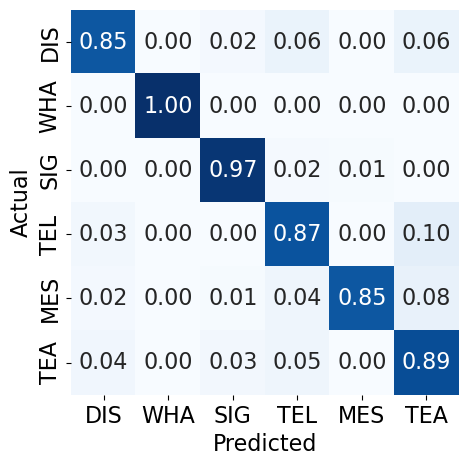

In [23]:
# results from experiment - we take result of first RF tree when no majority vote is obtained
do_conf_mat("noms_full_test_tree0", "NOMS_conf_mat.pdf")